# 3.8: 量子多体系统时演化的最优调控

超导等量子计算机的底层物理原理：受控量子动力学

## 哈密顿量 Hamiltonian

> 涉及到量子哈密顿量的概念，可以看 [2.8节的笔记](./2-8.ipynb)

哈密顿量决定量子态的演化，方程为

$|\varphi(T)\rangle = e^{-i\int_0^T \hat{H}(t)dt}|\varphi_0\rangle$

其中$\hat{H}(t)$为$t$时刻哈密顿量，$|\varphi_0\rangle$为量子初态，$|\varphi(T)\rangle$为演化$T$时间后的末态，$T$为时间演化总时长。

### Trotter-Suzuki 分解

 $$
 e^{-i\int_0^T \hat{H}(t)dt} \approx \prod_{k=0}^{K-1}e^{-i\tau\hat{H}(t_k)}
 $$

 > 简化版推导：
 > 1. 积分改求和，引入时间片 $\tau$
 > 2. 指数上的求和变成连乘
 > 
 > 详细推导：TODO，看书 3.8 节

#### 例子
以 6 个自旋的 XY（一维）模型为例，其哈密顿量为：

$$
\hat{H}(t) = \frac{1}{4}\sum_{n=0}^{4}(\hat{\sigma}_n^x\hat{\sigma}_{n+1}^x + \hat{\sigma}_n^y\hat{\sigma}_{n+1}^y) + \frac{1}{2}\sum_{n=0}^{5}h_n^x(t)\hat{\sigma}_n^x + \frac{1}{2}\sum_{n=0}^{5}h_n^z(t)\hat{\sigma}_n^z
$$

> 第一个 $\sum$ 项为耦合（相互作用）项，不含时间参数；第二个 $\sum$ 项是 x 方向的磁场项，第三个 $\sum$ 项是 z 方向的磁场项
> 
> 第一个 $\sum$ 项里没有变分参数，是两个泡利 x/y 门外积得到的双体门
>
> 磁场 $h_n^+(t)$ 与 $h_n^-(t)$ 为哈密顿量 $\hat{H}(t)$ 的"变分参数"
> 
> $\frac{1}{4}$ 和 $\frac{1}{2}$ 是因为泡利算符和自旋相差 $\frac{1}{2}$

把 $\hat{H}(t)$ 代入到 Trotter-Suzuki 分解里，得到

$$
e^{-i\tau\hat{H}(t_k)} = \prod_n e^{-\frac{i\tau}{4}(\hat{\sigma}_n^x\hat{\sigma}_{n+1}^x+\hat{\sigma}_n^y\hat{\sigma}_{n+1}^y)} \prod_n e^{-\frac{i\tau}{2}(h_{n,k}^x\hat{\sigma}_n^x+h_{n,k}^z\hat{\sigma}_n^z)} + O(\tau^2)
$$
其中：
* $\hat{U}_{n,n+1} = e^{-\frac{i\tau}{4}(\hat{\sigma}^x_n\hat{\sigma}^x_{n+1}+\hat{\sigma}^y_n\hat{\sigma}^y_{n+1})}$ 是作用到第n与n+1个自旋的二体算符
    * 没有变分参数
* $\hat{V}_n = e^{-\frac{it}{2}(h_{n,k}^x\hat{\sigma}_n^x+h_{n,k}^z\hat{\sigma}_n^z)}$ 是作用到第n个自旋的单体算符
    * 有变分参数
    * 可以看做为量子门的一种特殊的参数化形式
* $O(\tau^2)$ 是误差项，适用 Big-O Notation

上面的公式可以用下面的量子线路实现
![time-evolution-example](./images/time_evolution_example.png)

> 每层的结构可以不同，但是误差都是 $O(\tau^2)$，叫 Trotter 误差


## Code

In [1]:
# |default_exp networks.time_evolution
# |export

import torch
from einops import einsum
from torch import nn

### Utils

#### Gate Outer Product

In [2]:
# |export tensor_gates.functional
from einops import rearrange
from tensor_network.utils import check_quantum_gate


def gate_outer_product(*gates: torch.Tensor, matrix_form: bool = False) -> torch.Tensor:
    """
    Outer product of multiple quantum gates. This only deals with the case where the target qubits of gates are disjoint.
    Args:
        *gates: The quantum gates to be cross-multiplied.
        matrix_form: Whether the quantum gates are in matrix form.
    Returns:
        The cross product of the quantum gates.
    """
    gates_num = len(gates)
    assert gates_num >= 2, "at least 2 gates"
    num_qubits = [check_quantum_gate(gate) for gate in gates]
    gate_tensors = []
    for i, gate in enumerate(gates):
        if gate.ndim == 2 and gate.shape[0] == gate.shape[1]:  # if gate is in matrix form
            gate_tensors.append(gate.reshape([2] * (num_qubits[i] * 2)))
        else:
            gate_tensors.append(gate)
    gate_dim_names = []
    for i in range(gates_num):
        num_qubits_of_gate_i = num_qubits[i]
        gate_dim_names.append(
            {
                "left_dim_names": [f"g{i}l{j}" for j in range(num_qubits_of_gate_i)],
                "right_dim_names": [f"g{i}r{j}" for j in range(num_qubits_of_gate_i)],
            }
        )

    input_subexpressions = []
    for gate_dim_info in gate_dim_names:
        input_subexp = " ".join(gate_dim_info["left_dim_names"] + gate_dim_info["right_dim_names"])
        input_subexpressions.append(input_subexp)
    input_expression = ",".join(input_subexpressions)

    output_subexpressions = []
    for gate_dim_info in gate_dim_names:
        output_subexpressions.extend(gate_dim_info["left_dim_names"])
    for gate_dim_info in gate_dim_names:
        output_subexpressions.extend(gate_dim_info["right_dim_names"])
    output_expression = " ".join(output_subexpressions)

    einsum_expression = f"{input_expression} -> {output_expression}"
    gate_product = einsum(*gate_tensors, einsum_expression)

    if matrix_form:
        output_left_dim_num = len(output_subexpressions) // 2
        left_exp = " ".join(output_subexpressions[:output_left_dim_num])
        right_exp = " ".join(output_subexpressions[output_left_dim_num:])
        gate_product = rearrange(gate_product, f"{output_expression} -> ({left_exp}) ({right_exp})")
    return gate_product

In [3]:
# test gate_cross_product


def rand_gate_tensor(n: int):
    return torch.randn(*([2] * (n * 2)), dtype=torch.complex64)


for i in range(1, 5):
    gate1 = rand_gate_tensor(i)
    gate1_mat = gate1.reshape(2**i, 2**i)
    for j in range(1, 5):
        gate2 = rand_gate_tensor(j)
        gate2_mat = gate2.reshape(2**j, 2**j)
        kron12 = torch.kron(gate1_mat, gate2_mat)
        for l in range(1, 5):
            gate3 = rand_gate_tensor(l)
            gate3_mat = gate3.reshape(2**l, 2**l)

            product_mat_ref = torch.kron(kron12, gate3_mat)
            product_mat1 = gate_outer_product(gate1, gate2, gate3, matrix_form=True)

            assert torch.allclose(product_mat_ref, product_mat1), (
                f"{i=},{j=}\n {product_mat_ref} \n{product_mat1}"
            )
            product = gate_outer_product(gate1, gate2, gate3, matrix_form=False)
            product_mat2 = product.reshape(2 ** (i + j + l), 2 ** (i + j + l))
            assert torch.allclose(product_mat_ref, product_mat2), (
                f"{i=},{j=}\n {product_mat_ref} \n{product_mat2}"
            )

#### Spin Operator

In [ ]:
from tensor_network.tensor_gates.functional import pauli_operator
from typing import Literal

In [4]:
# |export tensor_gates.functional


def spin_operator(direction: Literal["X", "Y", "Z", "ID"]):
    """
    Return the spin operator for the given direction.
    Args:
        direction: The direction of the spin operator. Can be "X", "Y", "Z", or "ID".
    Returns:
        The spin operator for the given direction.
    """
    assert direction in ["X", "Y", "Z", "ID"], "direction must be one of X, Y, Z, ID"
    if direction == "ID":
        return pauli_operator(pauli="ID")
    return pauli_operator(pauli=direction) / 2

### Time Evolution Module

In [5]:
# |export
from torch import Tensor
from tensor_network.networks.adqc import ADQCNet
from tensor_network.tensor_gates.modules import QuantumGate
from typing import Set, Literal
from tensor_network.tensor_gates.functional import spin_operator


class PolarizationGate(QuantumGate):
    """
    A gate that applies a magnetic field to polarize a qubit.
    """

    def __init__(
        self,
        *,
        batched_input: bool,
        time_slice: float,
        target_qubit: int,
        h_directions: Set[Literal["x", "y", "z"]],
    ):
        """
        Initialize the PolarizationGate.

        Args:
            batched_input: Whether the input is batched.
            time_slice: The time slice width of the gate.
            target_qubit: The target qubit of the gate.
            h_directions: The directions of the spin operator.
        """
        assert isinstance(h_directions, set), "h_directions must be a list"
        assert 3 >= len(h_directions) > 0, "h_directions must be a non-empty set"
        assert all(direction in ["x", "y", "z"] for direction in h_directions), (
            "h_directions must contain only x, y, z"
        )
        assert time_slice > 0, "time_slice must be greater than 0"
        assert target_qubit >= 0, "target_qubit must be greater than or equal to 0"
        parameters = nn.ParameterDict(
            {
                direction: nn.Parameter(torch.randn(1), requires_grad=True)
                for direction in h_directions
            }
        )

        super().__init__(
            batched_input=batched_input,
            gate_params=parameters,
            requires_grad=True,
            target_qubit=target_qubit,
        )
        self.spin = nn.ParameterDict(
            {
                "x": nn.Parameter(spin_operator("X"), requires_grad=False),
                "y": nn.Parameter(spin_operator("Y"), requires_grad=False),
                "z": nn.Parameter(spin_operator("Z"), requires_grad=False),
            }
        )
        self.time_slice = time_slice
        self.h_directions = h_directions

    def forward(self, tensor: Tensor) -> Tensor:
        spin_matrix = 0
        for direction in self.h_directions:
            spin_matrix += self.gate_params[direction] * self.spin[direction]

        gate = torch.matrix_exp(-1j * self.time_slice * spin_matrix)
        return self.apply_gate(
            tensor=tensor,
            gate=gate,
            target_qubit=self.target_qubit,
        )


class ADQCTimeEvolution(nn.Module):
    def __init__(
        self,
        hamiltonian: torch.Tensor,
        num_qubits: int,
        time_steps: int,
        time_slice: float,
        h_directions: Set[Literal["x", "y", "z"]],
    ):
        super().__init__()
        assert hamiltonian.shape == (4, 4) or hamiltonian.shape == (2, 2, 2, 2), (
            "Hamiltonian must be a 4x4 matrix or 2x2x2x2 tensor"
        )
        if hamiltonian.shape == (2, 2, 2, 2):
            hamiltonian = hamiltonian.reshape(4, 4)
        assert num_qubits > 0, "Number of qubits must be greater than 0"
        assert time_steps > 0, "Time steps must be greater than 0"
        assert time_slice > 0, "Time slice must be greater than 0"
        U = torch.matrix_exp(-1j * time_slice * hamiltonian).reshape(2, 2, 2, 2)
        per_layer_gate_pattern = ADQCNet.calc_gate_target_qubit_positions(
            gate_pattern="brick", num_qubits=num_qubits
        )
        gates = []
        for _ in range(time_steps):
            # gates for coupling
            for position in per_layer_gate_pattern:
                gates.append(
                    QuantumGate(
                        batched_input=False,
                        gate_name="coupling",
                        target_qubit=list(position),
                        gate=U,
                        requires_grad=False,
                    )
                )
            # gates for polarization
            for qubit_idx in range(num_qubits):
                gates.append(
                    PolarizationGate(
                        batched_input=False,
                        time_slice=time_slice,
                        target_qubit=qubit_idx,
                        h_directions=h_directions,
                    )
                )

        self.net = nn.Sequential(*gates)

    def forward(self, tensor: Tensor) -> Tensor:
        return self.net(tensor)

### Training

In [6]:
from tensor_network import setup_ref_code_import
from Library.Hamiltonians import heisenberg
from Library.ED import ED_ground_state
from torch.optim import Adam
from tensor_network.tensor_utils import zeros_state
from tqdm.auto import tqdm
from matplotlib import pyplot as plt

From setup_ref_code_import:
  Added reference_code_path='/Users/zhiqiu/offline_code/personal/tensor_network/reference_code' to sys.path.
  You can import the reference code now.


#### Hyperparameters

In [7]:
num_qubits = 6  # 自旋个数
time_slice = 0.02  # Trotter切片宽度
num_slice = 50  # 切片次数
h_directions = set(["x", "z"])  # 磁场方向限制为x与z方向，y方向磁场为0
device = torch.device("cpu")
lr = 1e-1
it_time = 600

#### Get Target State

In [8]:
J_target = [1, 1, 1]  # 制备该哈密顿量（海森堡模型）基态
hamilt_t = heisenberg(J_target[0], J_target[1], J_target[2])
pos = [[n, n + 1] for n in range(num_qubits - 1)]
psi_target = ED_ground_state(hamilt_t.reshape(2, 2, 2, 2), pos)[1]
psi_target = torch.from_numpy(psi_target).flatten().to(device=device, dtype=torch.complex128)
target_state = psi_target.reshape([2] * num_qubits)
# TODO: check function `heisenberg` and `ED_ground_state`

#### Init Circuit

In [9]:
spin_x = spin_operator("X")
spin_y = spin_operator("Y")
hamilt = gate_outer_product(spin_x, spin_x) + gate_outer_product(spin_y, spin_y)

In [10]:
quantum_circuit = ADQCTimeEvolution(
    hamiltonian=hamilt,
    num_qubits=num_qubits,
    time_steps=num_slice,
    time_slice=time_slice,
    h_directions=h_directions,
).to(device=device)

#### Train

In [11]:
optimizer = Adam(quantum_circuit.parameters(), lr=lr)

In [12]:
losses = torch.empty(it_time)
init_state = zeros_state(num_qubits=num_qubits, dtype=target_state.dtype).to(device=device)

progress_bar = tqdm(range(it_time))

for t in progress_bar:
    state = quantum_circuit(init_state)
    loss = 1 - (state * target_state.conj()).sum().norm()
    l = loss.detach().cpu()
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses[t] = l
    progress_bar.set_description(f"Loss: {l:.4f}")

  0%|          | 0/600 [00:00<?, ?it/s]

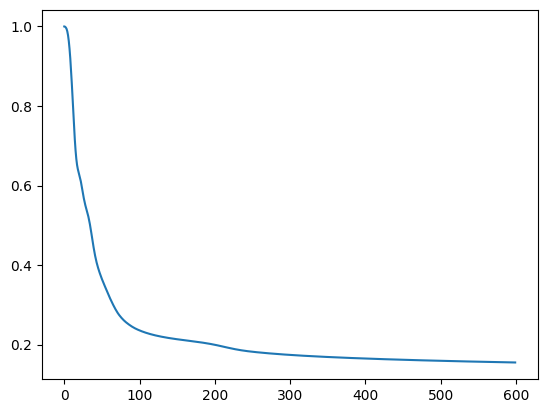

In [13]:
plt.plot(losses)
plt.show()